In [1]:
import pandas as pd
import keras
import tensorflow
import seaborn as sns
import csv
import spacy
import nltk
import re
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

In [2]:
amazon_data = pd.read_csv("amazon_cells_labelled.txt", header = None, delimiter= "\t", names = ["review", "sentiment"], quoting=csv.QUOTE_NONE)
yelp_data = pd.read_csv("yelp_labelled.txt", header = None, delimiter = "\t", names = ["review", "sentiment"], quoting=csv.QUOTE_NONE)
imdb_data = pd.read_csv("imdb_labelled.txt", header = None, delimiter = "\t", names = ["review", "sentiment"], quoting=csv.QUOTE_NONE)

In [3]:
amazon_data['site'] = 'amazon'
yelp_data['site']  = 'yelp'
imdb_data ['site']  = 'imdb'

In [4]:
data = pd.concat([amazon_data, yelp_data, imdb_data], ignore_index= True)

In [5]:
data

,review,sentiment,site
0,So there is no way for me to plug it in here i...,0,amazon
1,"Good case, Excellent value.",1,amazon
2,Great for the jawbone.,1,amazon
3,Tied to charger for conversations lasting more...,0,amazon
4,The mic is great.,1,amazon
...,...,...,...
2995,I just got bored watching Jessice Lange take h...,0,imdb
2996,"Unfortunately, any virtue in this film's produ...",0,imdb
2997,"In a word, it is embarrassing.",0,imdb
2998,Exceptionally bad!,0,imdb


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     3000 non-null   object
 1   sentiment  3000 non-null   int64 
 2   site       3000 non-null   object
dtypes: int64(1), object(2)
memory usage: 70.4+ KB


In [7]:
display(data)

,review,sentiment,site
0,So there is no way for me to plug it in here i...,0,amazon
1,"Good case, Excellent value.",1,amazon
2,Great for the jawbone.,1,amazon
3,Tied to charger for conversations lasting more...,0,amazon
4,The mic is great.,1,amazon
...,...,...,...
2995,I just got bored watching Jessice Lange take h...,0,imdb
2996,"Unfortunately, any virtue in this film's produ...",0,imdb
2997,"In a word, it is embarrassing.",0,imdb
2998,Exceptionally bad!,0,imdb


<Axes: xlabel='sentiment', ylabel='count'>

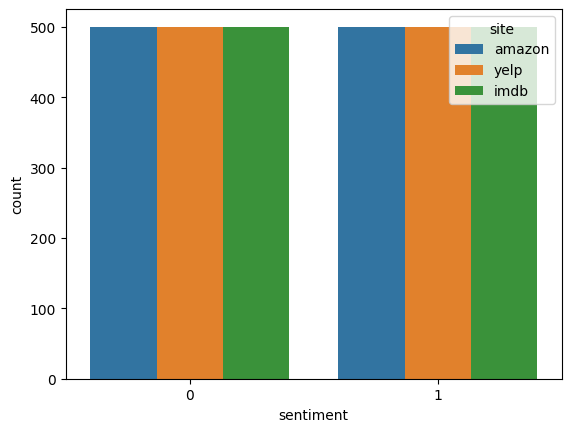

In [8]:
sns.countplot(data= data, x='sentiment', hue= 'site')

In [9]:
list_of_char = set()
for row in data['review']:
    for char in row:
        if char not in list_of_char:
            list_of_char.add(char)

In [47]:
list(list_of_char)[:25]

['g',
 'ê',
 '%',
 '0',
 '3',
 'X',
 'L',
 ')',
 "'",
 'V',
 'z',
 'p',
 '\x97',
 '.',
 'd',
 '6',
 ':',
 '-',
 '\x96',
 'u',
 'W',
 '*',
 'Y',
 'b',
 'f']

In [11]:
def remove_tags(text):
    #Removes any HTML tag
    Tag_re = re.compile(r'<[^>]+>')
    return Tag_re.sub('', text)

In [12]:
stop_words = set(stopwords.words('english'))

def token(text):
    #Makes it a token
    token = nltk.word_tokenize(text)
    #gets the root of the word
    lemma = nltk.WordNetLemmatizer()
    token = [lemma.lemmatize(word) for word in token]
    #removes stops words
    token = [word for word in token if word not in stop_words]
    clean = ' '.join(token)
    return clean


In [13]:
def clean(text):
    # remove html tags
    text = remove_tags(text)
    # punctuations and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    #removes single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # removes multiple spaces and just makes one space
    text = re.sub(r'\s+', ' ', text)
    #makes all strings lower case
    text = text.lower()
    text = token(text)
    return text

In [14]:
x = [clean(i) for i in data['review']]

In [15]:
data['review'] = x

In [16]:
y = data['sentiment']
X = data['review']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify= y)

In [17]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
train

,review,sentiment
2096,scene often funny occasionally touching charac...,1
2435,interesting premise billy drago always good da...,1
2331,seen waste time,0
1782,perfect someone like beer ice cold case even c...,1
1777,nutshell restaraunt smell like combination dir...,0
...,...,...
2671,raw sublimely moving,1
2273,truly take journey eye soul child,1
1534,terrible management,0
893,bad reception,0


In [18]:
word_num = []
for i in X_train:
    word_num.append(len(i.split(" ")))
max_padding = max(word_num)
max_padding

44

In [19]:
embedding_dim = 200

In [44]:
tokenizer = Tokenizer(filters='\t\n!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', oov_token= '[UNK]')
tokenizer.fit_on_texts(X_train)
list(tokenizer.word_index.items())[:10]

[('[UNK]', 1),
 ('wa', 2),
 ('good', 3),
 ('great', 4),
 ('movie', 5),
 ('phone', 6),
 ('film', 7),
 ('one', 8),
 ('time', 9),
 ('place', 10)]

In [21]:
vocab_size = len(tokenizer.word_index) + 1
print(f'Vocab Size : {len(tokenizer.word_index) + 1}')

Vocab Size : 4005


In [22]:
sequence = tokenizer.texts_to_sequences(X_train)
padded_sequences = pad_sequences(sequence, maxlen= max_padding, padding='post')

In [23]:
np.savetxt("train.csv", padded_sequences, delimiter=",", fmt='%d')

In [24]:
y_train.to_csv("train_target.csv")
y_test.to_csv("test_target.csv")

In [25]:
sequence[0]

[95, 514, 117, 781, 1087, 36, 1696, 86, 72]

In [26]:
padded_sequences[0]

array([  95,  514,  117,  781, 1087,   36, 1696,   86,   72,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])

In [27]:
tensorflow.random.set_seed(42)
model = tensorflow.keras.Sequential([
    tensorflow.keras.layers.Embedding(vocab_size, embedding_dim, input_length = 44),
    tensorflow.keras.layers.GlobalAveragePooling1D(),
    tensorflow.keras.layers.Dense(100, activation= 'relu'),
    tensorflow.keras.layers.Dropout(0.2),
    tensorflow.keras.layers.Dense(50, activation= 'relu'),
    tensorflow.keras.layers.Dropout(0.2),
    tensorflow.keras.layers.Dense(25, activation= 'relu'),
    tensorflow.keras.layers.Dropout(0.2),
    tensorflow.keras.layers.Dense(1, activation= 'sigmoid')])

model.compile(loss = 'binary_crossentropy',optimizer = Adam(learning_rate=0.001), metrics= ['accuracy'])

c:\Users\jacob\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [28]:
early_stop = EarlyStopping(patience = 4)
history = model.fit(padded_sequences, y_train, epochs= 100, batch_size=125, validation_split=0.2, callbacks= [early_stop], verbose = True)

Epoch 1/100


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.5238 - loss: 0.6921 - val_accuracy: 0.4500 - val_loss: 0.6941
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5113 - loss: 0.6924 - val_accuracy: 0.4521 - val_loss: 0.6942
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5333 - loss: 0.6919 - val_accuracy: 0.4521 - val_loss: 0.6952
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5515 - loss: 0.6907 - val_accuracy: 0.4750 - val_loss: 0.6917
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5620 - loss: 0.6881 - val_accuracy: 0.6417 - val_loss: 0.6881
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5400 - loss: 0.6892 - val_accuracy: 0.5667 - val_loss: 0.6867
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5708 - loss: 0.6849 - val_accuracy: 0.7271 - val_loss: 0.6823
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5636 - loss: 0.6863 - val_accuracy: 0.5542 - val_l

In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 44, 200)        │       801,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 200)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,482,355 (9.47 MB)

 Trainable params: 827,451 (3.16 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,654,904 (6.31 MB)

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuarcy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

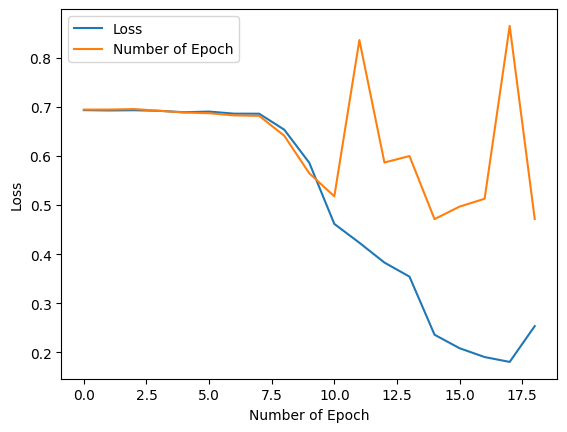

In [31]:
plt.plot(loss, label = 'Loss')
plt.plot(val_loss, label = 'Number of Epoch')
plt.xlabel("Number of Epoch")
plt.ylabel("Loss")
plt.legend()

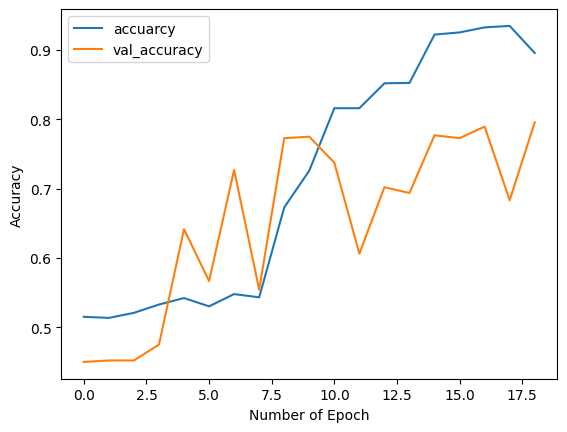

In [32]:
plt.plot(accuarcy, label = 'accuarcy')
plt.plot(val_accuracy, label = 'val_accuracy')
plt.xlabel("Number of Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [33]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_pad = pad_sequences(test_sequences, max_padding, padding='post')

In [34]:
np.savetxt("test.csv", test_pad, delimiter=",", fmt='%d')

In [35]:
score = model.evaluate(test_pad,y_test, verbose=0)
print(f'Model loss is {score[0]:.2f}, the Test Accurcy is {score[1]:.2f}')

Model loss is 0.45, the Test Accurcy is 0.80


In [36]:
model.save("NLP_NN.h5") 